In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, ZeroPadding2D, PReLU, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.layers.experimental.preprocessing import Resizing

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

height_lr = 136
width_lr = 180
channels = 3
shape_lr = (height_lr, width_lr, channels)
shape_hr = (4*height_lr, 4*width_lr, channels)
data_num = 7
data_dir = f"../../datasets/dataset_0{data_num}/"
activation = 'relu'
regularizer = regularizers.l1(10e-10)
adam = Adam(learning_rate=0.0003)
dropout_ratio = 0.25

In [2]:
def down_block(x, i, filters):
    x = Conv2D(filters*i, (3,3), padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(x)
    x = Conv2D(filters*i, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation, activity_regularizer=regularizer)(x)
    return x

def up_block(x, i, filters):
    x = Conv2DTranspose(filters*(2**i), (3,3),padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(x)
    x = Conv2D(filters*(2**i), (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation, activity_regularizer=regularizer)(x)
    return x

img_input = Input(shape_lr)

l1_1 = Conv2D(64, (7,7), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(img_input)
l1_2 = BatchNormalization()(l1_1)
l1_3 = Activation(activation=activation, activity_regularizer=regularizer)(l1_2)

x = l1_3
for i in range(1, 3):
    x = down_block(x, i, 128)

for i in range(2, -1, -1):
    x = up_block(x, i, 32)

l2_1 = Conv2D(3, (7,7), padding='same', strides=(1,1),
                activation=activation, activity_regularizer=regularizer)(x)

autoencoder = Model(img_input, l2_1)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 136, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 136, 180, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 136, 180, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 136, 180, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 90, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 90, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 90, 128)       512   

In [2]:
img_input = Input(shape_lr)

l1_1 = Conv2D(64, (7,7), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(img_input)
l1_2 = BatchNormalization()(l1_1)
l1_3 = Activation(activation=activation, activity_regularizer=regularizer)(l1_2)

l2_1 = Conv2D(128, (3,3), padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l2_1)
l2_3 = BatchNormalization()(l2_2)
l2_4 = Activation(activation=activation, activity_regularizer=regularizer)(l2_3)

l3_1 = Conv2D(256, (3,3), padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l2_4)
l3_2 = Conv2D(256, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l3_1)
l3_3 = BatchNormalization()(l3_2)
l3_4 = Activation(activation=activation, activity_regularizer=regularizer)(l3_3)

l4_1 = Conv2DTranspose(128, (3,3),padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l3_4)
l4_2 = Conv2D(128, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l4_1)
l4_3 = BatchNormalization()(l4_2)
l4_4 = Activation(activation=activation, activity_regularizer=regularizer)(l4_3)

l5 = add([l4_4, l2_4])

l6_1 = Conv2DTranspose(64, (3,3),padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l5)
l6_2 = Conv2D(64, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l6_1)
l6_3 = BatchNormalization()(l6_2)
l6_4 = Activation(activation=activation, activity_regularizer=regularizer)(l6_3)

l7 = add([l6_4, l1_3])

l8_1 = Conv2DTranspose(32, (3,3),padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l7)
l8_2 = Conv2D(32, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l8_1)
l8_3 = BatchNormalization()(l8_2)
l8_4 = Activation(activation=activation, activity_regularizer=regularizer)(l8_3)

l9 = Conv2D(3, (7,7), padding='same', strides=(1,1),
                activation=activation, activity_regularizer=regularizer)(l8_4)

autoencoder = Model(img_input, l9)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 136, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 136, 180, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 136, 180, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 136, 180, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [4]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4, dim=(272, 360, 3),
                    n_channels=1, n_classes=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        #print(list_IDs)

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(f'Batch index: {index}')
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'full', filename)
                image_y = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'half', filename)
                image_x = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        #print(f'Y: {Y[10, 10, :]}')
        #print(f'X: {X[10, 10, :]}')
        #print(f'Length of X: {len(X)}')
        return X, Y

In [5]:
files = os.listdir(data_dir+'full')
dataGenerator = DataGenerator(files[:32000])
history = autoencoder.fit(dataGenerator, verbose=1)

8000/8000 [==============================] - 627s 78ms/step - loss: 0.0125


[0.41078431 0.46470588 0.27352941]
[[0.41078431 0.46470588 0.27352941]]


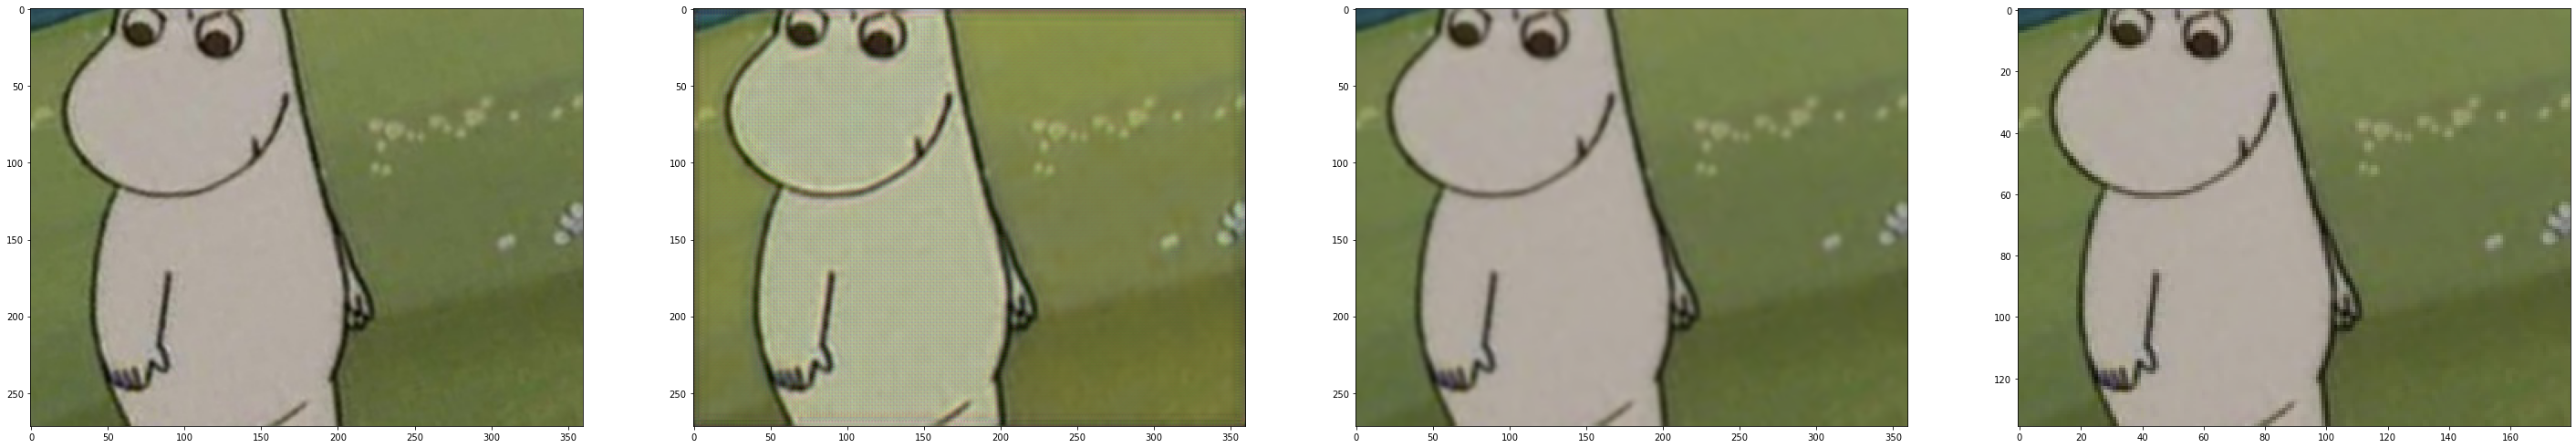

In [10]:
test_image = files[random.randint(0, len(files))]
#test_image = files[100]
test_image = pyplot.imread(os.path.join(data_dir+'full', test_image))
small_image = resize(test_image,(test_image.shape[0]//2, test_image.shape[1]//2))
print(small_image[10, 10, :])
pred_image = np.expand_dims(small_image, 0)
print(pred_image[:, 10, 10, :])
pred_image = 255 * autoencoder.predict(pred_image)
#print(pred_image[0][:10])
pred_image = np.array(pred_image, dtype=int)
#mse_og = np.square(test_image - small_image).mean(axis=None)
#mse = np.square(test_image - pred_image).mean(axis=None)
#print(f'MSE:\nOriginal: {mse_og}\nAutoencoder: {mse}')
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(test_image)
ax = plt.subplot(10, 10, 2)
plt.imshow(pred_image[0])
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(small_image, (2*small_image.shape[0], 2*small_image.shape[1])))
ax = plt.subplot(10, 10, 4)
plt.imshow(small_image)